In [ ]:
pip install keras-tcn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.3 MB/s eta 0:00:00


In [ ]:
# general
import numpy as np
import pandas as pd
import random
from google.colab import drive
from scipy.ndimage import gaussian_filter1d
# keras
from tcn import TCN
from keras.layers import Dense, Input, Lambda, concatenate, UpSampling1D, Attention, GRU
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import *

#general
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import datetime
now = datetime.datetime.now
from sklearn.model_selection import train_test_split


from sklearn.metrics import mean_squared_error
from math import sqrt
# length of data sequences
timesteps = 104
# dimension of data sequences
n_dim = 80
batch_size = 2

In [ ]:
drive.mount('/content/drive')
dir_name_samples ='/content/drive/My Drive/new_kimore/Preprocessed_data/Exercise4_data.csv'
dir_name_labels ='/content/drive/My Drive/new_kimore/Preprocessed_data/Labels_ex4.csv'
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [ ]:
X_values = pd.read_csv(dir_name_samples, delimiter=',', encoding='utf-8')
print(X_values.shape)
# # Initialize the MinMaxScaler

# scaler = StandardScaler()
# # Fit and transform the data using the scaler
# scaled_data = scaler.fit_transform(X_values)

# # Create a new DataFrame with the scaled data
# scaled_df = pd.DataFrame(scaled_data, columns=X_values.columns)


# # Extract the underlying NumPy array
# numpy_2d_array = scaled_df.values
# #numpy_2d_array = X_values.values
# # Reshape the 2D array into a 3D array (207, 100, 80)
# X_train = numpy_2d_array.reshape(207, 100, 80)
# # The temporal pyramid requires that the length of the data sequences is divisible by 8.
# # The original length was 100 time steps, so we will repeat the first and last 2 data vectors to obtain sequences with 104 time steps
# X_train = np.concatenate((X_train[:,:2,:], X_train, X_train[:,-3:-1,:]), axis = 1)
numpy_2d_array = X_values.values
X_train = numpy_2d_array.reshape(210,100, 80)
# Calculate the mean along the specified axes (axis=0, axis=1, and axis=2) to obtain a mean value for the entire array
mean_value = X_train.mean(axis=(0, 1, 2))

# Subtract the mean from the entire array to achieve zero mean
X_train -= mean_value

# Calculate the maximum and minimum values in the array
max_value = X_train.max()
min_value = X_train.min()

# Normalize the array to a range between -1 and 1
data = 2 * (X_train - min_value) / (max_value - min_value) - 1
smoothed_data = np.empty_like(X_train)
for channel in range(80):
    smoothed_data[:, :, channel] = gaussian_filter1d(data[:, :, channel], sigma=5)
X_train=smoothed_data
X_train = np.concatenate((X_train[:,:2,:], X_train, X_train[:,-3:-1,:]), axis = 1)
#-----------labels------------------------------------
Y_values = pd.read_csv(dir_name_labels)
#change the secon column to the labels
y_values= Y_values['EX4'].values

reshaped_data_y = y_values.reshape(210, 1)
# Fit and transform the data using the scaler
#scaler2 = MinMaxScaler(feature_range=(0, 1))
#y_train = scaler2.fit_transform(reshaped_data_y)
min_value = np.min(reshaped_data_y)
max_value = np.max(reshaped_data_y)

# Normalize the vector to be in the range [-1, 1]
y_train = (reshaped_data_y - min_value) / (max_value - min_value)

print('Training sequences dimension', X_train.shape)
print('Training labels dimension', y_train.shape)

(21000, 80)
Training sequences dimension (210, 104, 80)
Training labels dimension (210, 1)


In [ ]:
# Split the data into training and validation sets
train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.3)
# Split your dataset into a training set (60%) and a combined validation-testing set (40%)
train_x, X_val_test, train_y, y_val_test = train_test_split(X_train, y_train, test_size=0.4, random_state=42)

# Split the combined validation-testing set (40%) into a validation set (20%) and a test set (20%)
valid_x, test_x, valid_y, test_y = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Now, you have X_train, y_train for training (60%), X_val, y_val for validation (20%), and X_test, y_test for testing (20%)
print('Training data', train_x.shape)
print('Validation data', valid_x.shape)
print('Training label', train_y.shape)
print('Validation label', valid_y.shape)

Training data (126, 104, 80)
Validation data (42, 104, 80)
Training label (126, 1)
Validation label (42, 1)


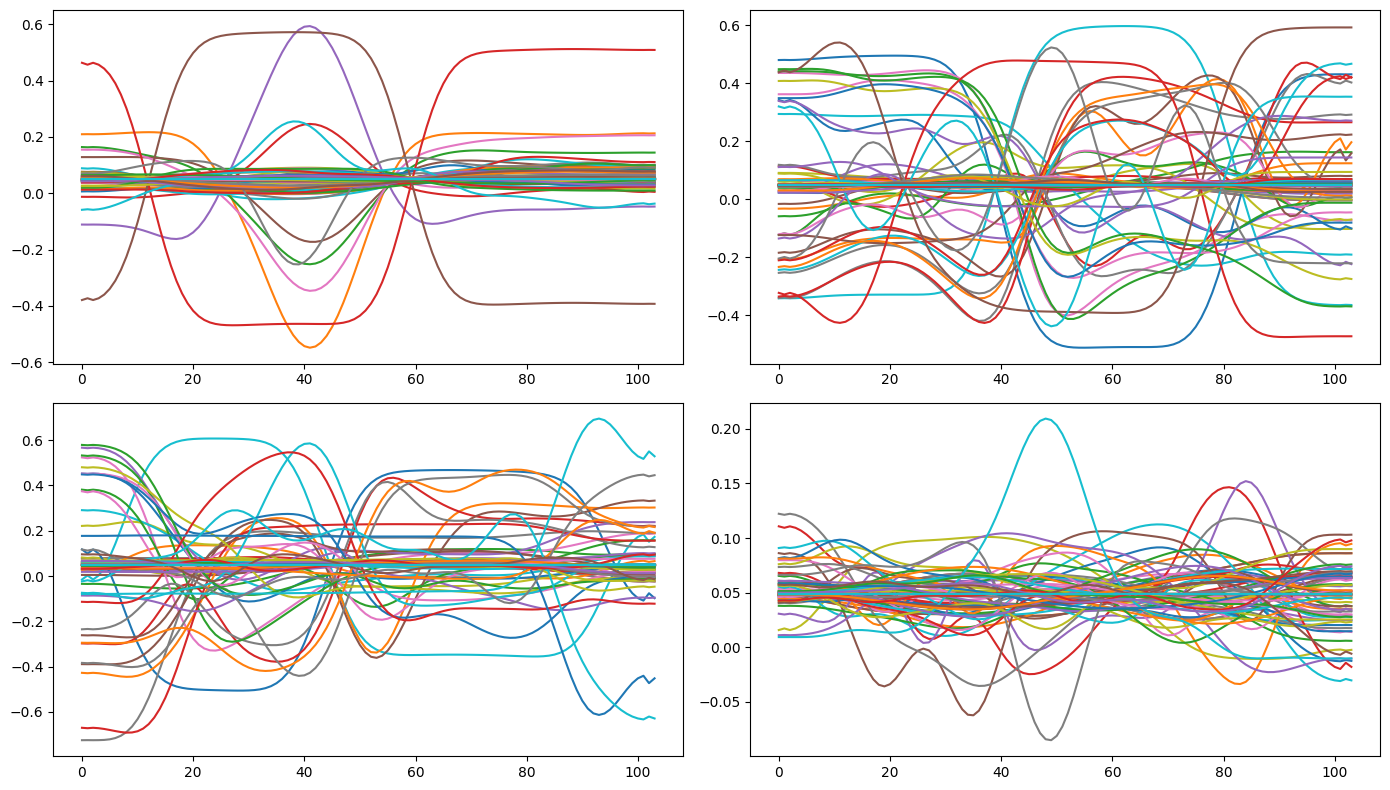

In [ ]:
# Plot the first and last sequences in the training and validation data
plt.figure(figsize = (14,8))
plt.subplot(2,2,1)
plt.plot(train_x[0])
plt.subplot(2,2,2)
plt.plot(train_x[-1])
plt.subplot(2,2,3)
plt.plot(valid_x[0])
plt.subplot(2,2,4)
plt.plot(valid_x[-1])
plt.tight_layout()
plt.show()

In [ ]:
# Reduce the data length by a factor of 2, 4, and 8
# The reduced sequences will be used as inputs to the temporal pyramid subnetwork
trainx_2 = np.zeros((train_x.shape[0], int(train_x.shape[1]/2), train_x.shape[2]))
validx_2 = np.zeros(trainx_2.shape)
testx_2 = np.zeros(trainx_2.shape)
trainx_4 = np.zeros((train_x.shape[0], int(train_x.shape[1]/4), train_x.shape[2]))
validx_4 = np.zeros(trainx_4.shape)
testx_4 = np.zeros(trainx_4.shape)
trainx_8 = np.zeros((train_x.shape[0], int(train_x.shape[1]/8), train_x.shape[2]))
validx_8 = np.zeros(trainx_8.shape)
testx_8 = np.zeros(trainx_8.shape)
trainx_2 = train_x[:,::2,:]
validx_2 = valid_x[:,::2,:]
testx_2 = test_x[:,::2,:]
trainx_4 = train_x[:,::4,:]
validx_4 = valid_x[:,::4,:]
testx_4 = test_x[:,::4,:]
trainx_8 = train_x[:,::8,:]
validx_8 = valid_x[:,::8,:]
testx_8 = test_x[:,::8,:]

In [ ]:
trainx =  train_x
validx =  valid_x
testx =  test_x

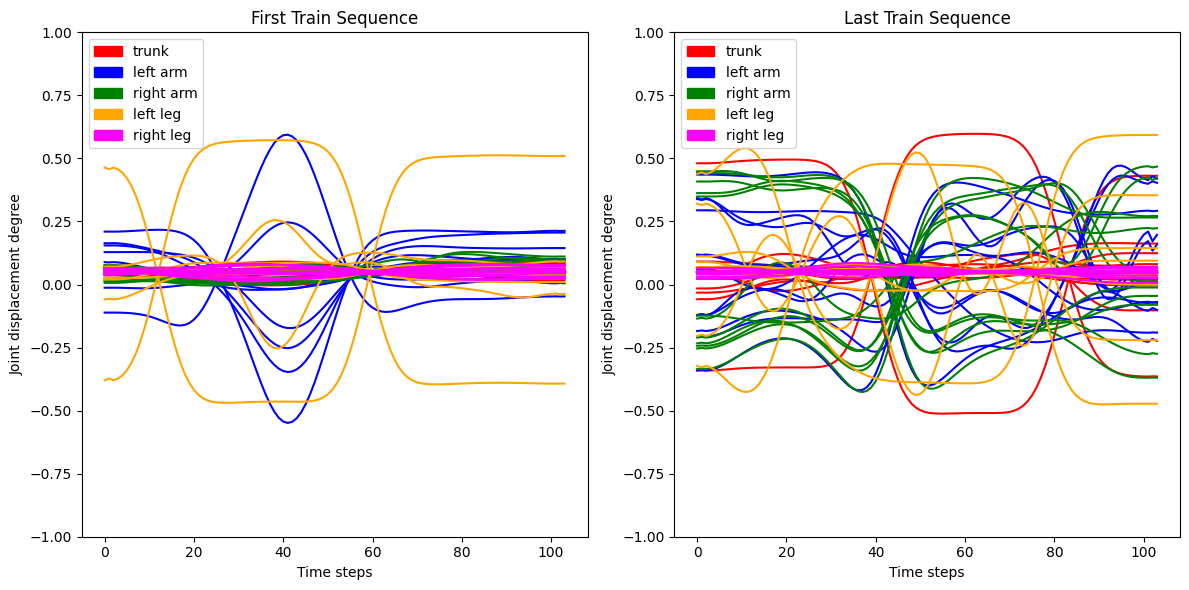

In [ ]:
import matplotlib.patches as mpatches
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.plot(trainx[0,:,0:16], color='red')
plt.plot(trainx[0,:,16:32], color='blue')
plt.plot(trainx[0,:,32:48], color='green')
plt.plot(trainx[0,:,48:64], color='orange')
plt.plot(trainx[0,:,64:80], color='magenta')
plt.ylim([-1,1])
# Create custom proxy artists for the legends
red_patch = mpatches.Patch(color='red', label='trunk')
blue_patch = mpatches.Patch(color='blue', label='left arm')
green_patch = mpatches.Patch(color='green', label='right arm')
orange_patch = mpatches.Patch(color='orange', label='left leg')
magenta_patch = mpatches.Patch(color='magenta', label='right leg')
# Create the legends using the proxy artists
plt.legend(handles=[red_patch, blue_patch,green_patch,orange_patch,magenta_patch], loc='upper left')
plt.xlabel('Time steps')
plt.ylabel('Joint displacement degree')
plt.title('First Train Sequence')
plt.subplot(1,2,2)
plt.plot(trainx[-1,:,0:16], color='red')
plt.plot(trainx[-1,:,16:32], color='blue')
plt.plot(trainx[-1,:,32:48], color='green')
plt.plot(trainx[-1,:,48:64], color='orange')
plt.plot(trainx[-1,:,64:80], color='magenta')
plt.ylim([-1,1])
# Create custom proxy artists for the legends
red_patch = mpatches.Patch(color='red', label='trunk')
blue_patch = mpatches.Patch(color='blue', label='left arm')
green_patch = mpatches.Patch(color='green', label='right arm')
orange_patch = mpatches.Patch(color='orange', label='left leg')
magenta_patch = mpatches.Patch(color='magenta', label='right leg')
# Create the legends using the proxy artists
plt.legend(handles=[red_patch, blue_patch,green_patch,orange_patch,magenta_patch], loc='upper left')
plt.xlabel('Time steps')
plt.ylabel('Joint displacement degree')
plt.title('Last Train Sequence')
plt.tight_layout()
plt.show()

In [ ]:
def createTCNLayers(input, timesteps, n_dim):
    print('shape of input:: ', input.shape)

    tcn_layer = TCN(input_shape=(timesteps, n_dim), nb_filters=12,kernel_size=3,nb_stacks=1,dilations=(1, 2, 4, 8, 16, 32),
        padding='causal',use_skip_connections=True,dropout_rate=0.05,return_sequences=True,
        activation='relu',kernel_initializer='he_normal',use_batch_norm=False,use_layer_norm=False,use_weight_norm=False)(input)

    print('shape of tcn_layer: ', tcn_layer.shape)

    return tcn_layer

In [ ]:
def getTCNLayers(input_f, input_2, input_4, input_8, timesteps, n_dim):

    print('--------------------------xxxx-----------------------------')
    tcn_1 = createTCNLayers(input_f, timesteps, n_dim)

    tcn_2 = createTCNLayers(input_2, timesteps, n_dim)
    #up_tcn_2 = UpSampling1D(size = 2)(tcn_2)
    print('tcn-2: ', tcn_2.shape)

    tcn_3 = createTCNLayers(input_4, timesteps, n_dim)
    #up_tcn_3 = UpSampling1D(size = 4)(tcn_3)
    print('tcn-3: ', tcn_3.shape)

    tcn_5 = createTCNLayers(input_8, timesteps, n_dim)
    #up-tcn_4 = UpSampling1D(size = 8)(tcn_4)
    print('tcn-5: ', tcn_5.shape)

    final_tcn = concatenate([tcn_1, tcn_2, tcn_3, tcn_5], axis=1)
    print('final_tcn: ', final_tcn.shape)
    print('--------------------------xxxx-----------------------------')

    return final_tcn

In [ ]:
n_dim = 80 # dimension after reordering the data into body parts
n_dim1 = 16 # dimension of indiviudal body parts
n_dim2 = 16
n_dim3 = 16 # legs dimension
# Build the model ...

#### Full scale sequences
seq_input = Input(shape = (timesteps,n_dim), name = 'full_scale')

seq_input_trunk = Lambda(lambda x: x[:, :, 0:16])(seq_input)
seq_input_left_arm = Lambda(lambda x: x[:, :, 16:32])(seq_input)
seq_input_right_arm = Lambda(lambda x: x[:, :, 32:48])(seq_input)
seq_input_left_leg = Lambda(lambda x: x[:, :, 48:64])(seq_input)
seq_input_right_leg = Lambda(lambda x: x[:, :, 64:80])(seq_input)

#### Half scale sequences
seq_input_2 = Input(shape=(int(timesteps/2), n_dim), name='half_scale')

seq_input_trunk_2 = Lambda(lambda x: x[:, :, 0:16])(seq_input_2)
seq_input_left_arm_2 = Lambda(lambda x: x[:, :, 16:32])(seq_input_2)
seq_input_right_arm_2 = Lambda(lambda x: x[:, :, 32:48])(seq_input_2)
seq_input_left_leg_2 = Lambda(lambda x: x[:, :, 48:64])(seq_input_2)
seq_input_right_leg_2 = Lambda(lambda x: x[:, :, 64:80])(seq_input_2)

#### Quarter scale sequences
seq_input_4 = Input(shape=(int(timesteps/4), n_dim), name='quarter_scale')

seq_input_trunk_4 = Lambda(lambda x: x[:, :, 0:16])(seq_input_4)
seq_input_left_arm_4 = Lambda(lambda x: x[:, :, 16:32])(seq_input_4)
seq_input_right_arm_4 = Lambda(lambda x: x[:, :, 32:48])(seq_input_4)
seq_input_left_leg_4 = Lambda(lambda x: x[:, :, 48:64])(seq_input_4)
seq_input_right_leg_4 = Lambda(lambda x: x[:, :, 64:80])(seq_input_4)

#### Eighth scale sequences
seq_input_8 = Input(shape=(int(timesteps/8), n_dim), name='eighth_scale')

seq_input_trunk_8 = Lambda(lambda x: x[:, :, 0:16])(seq_input_8)
seq_input_left_arm_8 = Lambda(lambda x: x[:, :, 16:32])(seq_input_8)
seq_input_right_arm_8 = Lambda(lambda x: x[:, :, 32:48])(seq_input_8)
seq_input_left_leg_8 = Lambda(lambda x: x[:, :, 48:64])(seq_input_8)
seq_input_right_leg_8 = Lambda(lambda x: x[:, :, 64:80])(seq_input_8)

concat_trunk = getTCNLayers(seq_input_trunk, seq_input_trunk_2, seq_input_trunk_4, seq_input_trunk_8,
                            timesteps, n_dim1)
concat_left_arm = getTCNLayers(seq_input_left_arm, seq_input_left_arm_2, seq_input_left_arm_4, seq_input_left_arm_8,
                               timesteps, n_dim2)
concat_right_arm = getTCNLayers(seq_input_right_arm, seq_input_right_arm_2, seq_input_right_arm_4, seq_input_right_arm_8,
                               timesteps,n_dim2)
concat_left_leg = getTCNLayers(seq_input_left_leg, seq_input_left_leg_2, seq_input_left_leg_4, seq_input_left_leg_8,
                               timesteps, n_dim3)
concat_right_leg = getTCNLayers(seq_input_right_leg, seq_input_right_leg_2, seq_input_right_leg_4, seq_input_right_leg_8,
                               timesteps, n_dim3)

concat = concatenate([concat_trunk, concat_left_arm, concat_right_arm, concat_left_leg, concat_right_leg], axis=-1)

tcn_layer_final = TCN(nb_filters=12,kernel_size=3,nb_stacks=1,dilations=(1, 2, 4, 8),
        padding='same',use_skip_connections=True,dropout_rate=0.05,return_sequences=True,
        activation='relu',kernel_initializer='he_normal',use_batch_norm=False,use_layer_norm=False,
                      use_weight_norm=False)(concat)

tcn_layer_final_1 = TCN(nb_filters=8,kernel_size=2,nb_stacks=1,dilations=(1, 2, 4),
        padding='same',use_skip_connections=True,dropout_rate=0.05,return_sequences=True,
        activation='relu',kernel_initializer='he_normal',use_batch_norm=True,use_layer_norm=False,
                        use_weight_norm=False)(tcn_layer_final)

tcn_layer_final_2 = TCN(nb_filters=6,kernel_size=3,nb_stacks=1,dilations=(1, 2),
        padding='same',use_skip_connections=True,dropout_rate=0.05,return_sequences=False,
        activation='relu',kernel_initializer='he_normal',use_batch_norm=False,use_layer_norm=False,
                        use_weight_norm=False)(tcn_layer_final_1)

print('shape of tcn_layer_final: ', tcn_layer_final_2.shape)



out = Dense(1, activation = 'linear')(tcn_layer_final_2)

print('shape of out: ', out.shape)

model = Model(inputs=[seq_input, seq_input_2, seq_input_4, seq_input_8], outputs=out)


--------------------------xxxx-----------------------------
shape of input::  (None, 104, 16)
shape of tcn_layer:  (None, 104, 12)
shape of input::  (None, 52, 16)
shape of tcn_layer:  (None, 52, 12)
tcn-2:  (None, 52, 12)
shape of input::  (None, 26, 16)
shape of tcn_layer:  (None, 26, 12)
tcn-3:  (None, 26, 12)
shape of input::  (None, 13, 16)
shape of tcn_layer:  (None, 13, 12)
tcn-5:  (None, 13, 12)
final_tcn:  (None, 195, 12)
--------------------------xxxx-----------------------------
--------------------------xxxx-----------------------------
shape of input::  (None, 104, 16)
shape of tcn_layer:  (None, 104, 12)
shape of input::  (None, 52, 16)
shape of tcn_layer:  (None, 52, 12)
tcn-2:  (None, 52, 12)
shape of input::  (None, 26, 16)
shape of tcn_layer:  (None, 26, 12)
tcn-3:  (None, 26, 12)
shape of input::  (None, 13, 16)
shape of tcn_layer:  (None, 13, 12)
tcn-5:  (None, 13, 12)
final_tcn:  (None, 195, 12)
--------------------------xxxx-----------------------------
----------

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 full_scale (InputLayer)     [(None, 104, 80)]            0         []                            
                                                                                                  
 half_scale (InputLayer)     [(None, 52, 80)]             0         []                            
                                                                                                  
 quarter_scale (InputLayer)  [(None, 26, 80)]             0         []                            
                                                                                                  
 eighth_scale (InputLayer)   [(None, 13, 80)]             0         []                            
                                                                                              

In [ ]:
import tracemalloc
tracemalloc.start()
#create call backs
save_dir='/content/drive/My Drive/new_kimore/'
checkpoint = ModelCheckpoint(save_dir+'modelEX4.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='min')
# define our early stopping
early_stop = EarlyStopping(
    monitor='loss',
    min_delta=0.001,
    patience=70,
    verbose=1,
    mode='min',
    restore_best_weights=True)
callbacks_list = [early_stop, checkpoint]## This saves the best model

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
t = now()

early_stopping = EarlyStopping(monitor='val_loss', patience = 75)

history = model.fit([trainx, trainx_2, trainx_4, trainx_8], train_y, batch_size=7, epochs=400, verbose=1,
                validation_data=([validx, validx_2, validx_4, validx_8], valid_y), callbacks = callbacks_list)

print('Training time: %s' % (now() - t))

Epoch 1/400
18/18 [==============================] - ETA: 0s - loss: 1.8653
Epoch 1: val_loss improved from inf to 0.85674, saving model to /content/drive/My Drive/new_kimore/modelEX4.h5
18/18 [==============================] - 267s 2s/step - loss: 1.8653 - val_loss: 0.8567
Epoch 2/400
18/18 [==============================] - ETA: 0s - loss: 0.5076
Epoch 2: val_loss improved from 0.85674 to 0.35277, saving model to /content/drive/My Drive/new_kimore/modelEX4.h5
18/18 [==============================] - 10s 562ms/step - loss: 0.5076 - val_loss: 0.3528
Epoch 3/400
18/18 [==============================] - ETA: 0s - loss: 0.2847
Epoch 3: val_loss improved from 0.35277 to 0.10924, saving model to /content/drive/My Drive/new_kimore/modelEX4.h5
18/18 [==============================] - 9s 529ms/step - loss: 0.2847 - val_loss: 0.1092
Epoch 4/400
18/18 [==============================] - ETA: 0s - loss: 0.2309
Epoch 4: val_loss did not improve from 0.10924
18/18 [==============================] - 

In [ ]:
print(tracemalloc.get_traced_memory())
# stopping the library
tracemalloc.stop()

(135745460, 137921904)


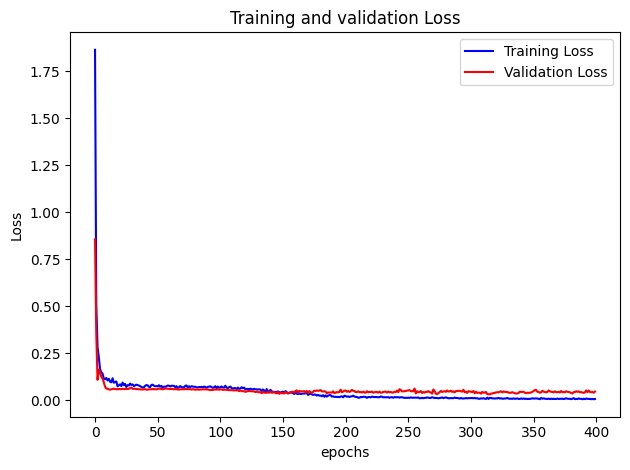

Training loss 0.00583117688074708
Validation loss 0.03174339979887009


In [ ]:
# Plot the results
plt.figure(1)
plt.plot(history.history['loss'], 'b', label = 'Training Loss')
plt.title('Training and validation Loss')
plt.plot(history.history['val_loss'], 'r', label = 'Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
# Print the minimum loss
print("Training loss", np.min(history.history['loss']))
print("Validation loss",np.min(history.history['val_loss']))

2/2 [==============================] - 0s 53ms/step


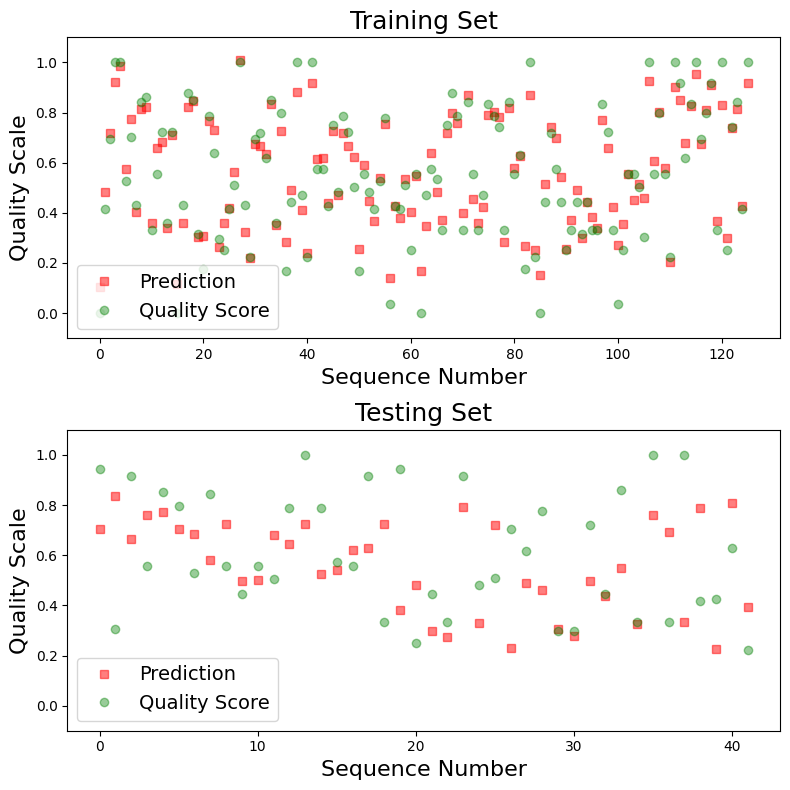

In [ ]:
# Plot the prediction of the model for the training and validation sets
import tensorflow as tf
from keras.models import load_model
from keras.initializers import glorot_uniform
# Load the best model's weights
best_model = load_model('/content/drive/My Drive/new_kimore/modelEX4.h5', custom_objects={'TCN': TCN, 'GlorotUniform': glorot_uniform()})

pred_train = best_model.predict([trainx, trainx_2, trainx_4, trainx_8])

pred_test = best_model.predict([testx, testx_2, testx_4, testx_8])

plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.plot(pred_train,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
plt.plot(train_y,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
plt.ylim([-0.1,1.1])
plt.title('Training Set',fontsize=18)
plt.xlabel('Sequence Number',fontsize=16)
plt.ylabel('Quality Scale',fontsize=16)
plt.legend(loc=3, prop={'size':14}) # loc:position
plt.subplot(2,1,2)
plt.plot(pred_test,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
plt.plot(valid_y,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
plt.title('Testing Set',fontsize=18)
plt.ylim([-0.1,1.1])
plt.xlabel('Sequence Number',fontsize=16)
plt.ylabel('Quality Scale',fontsize=16)
plt.legend(loc=3, prop={'size':14}) # loc:position
plt.tight_layout()

plt.show()

In [ ]:
test_dev = abs(pred_test-test_y)
# Cumulative deviation
mean_abs_dev = np.mean(test_dev)
# RMS deviation
#MSE
MSE=mean_squared_error(pred_test, test_y)
#MAPE
MAPE=np.mean(np.abs((pred_test-test_y)/test_y))*100
print('MSE:',MSE)
rms_dev = np.sqrt(mean_squared_error(pred_test, test_y))
print('Mean absolute deviation:', mean_abs_dev)
print('RMS deviation:', rms_dev)
print('MAPE:',MAPE)

MSE: 0.08782267504503723
Mean absolute deviation: 0.277125088942826
RMS deviation: 0.2963489076157313
MAPE: inf
